## Dependencies:
- Python3
- ase
- spglib

## Key references:

- Section 2.1 of: https://iopscience.iop.org/article/10.1088/0953-8984/19/25/256201
- spglib python interface: https://atztogo.github.io/spglib/python-spglib.html#get-symmetry
- spglib paper: https://arxiv.org/pdf/1808.01590.pdf

### Notes from spglib paper:
**Space group operations:**     

$\forall \vec{x}^{\prime} = \underline{\underline{W}}\vec{x} + \vec{w}$

Gives same atom type on site $\vec{x}$ as on site $\vec{x}^{\prime}$.

**Hall symbols:**

(From wikipedia): Space group notation with an explicit origin. Rotation, translation and axis-direction symbols are clearly separated and inversion centers are explicitly defined. The construction and format of the notation make it particularly suited to computer generation of symmetry information. 

Space group is identified by spglib by comparing space group operations determined as described above to the tabulated space group operations in Hall notation. The origin shift is also obtained during this matching step **this may be missing from my analysis below!!**

It appears that `get_symmetry` may just use above while `get_symmetry_from_database` takes into account Hall number. From testing below, symm op outputs appear to be the same??

**spglib accounts for periodicity:**
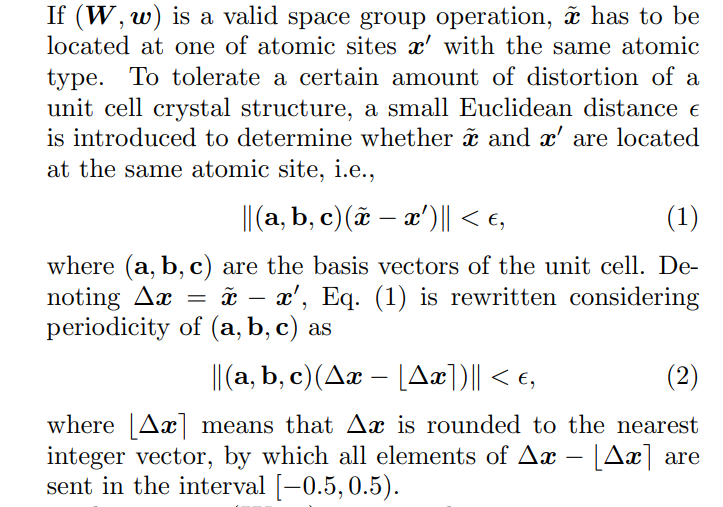

In [1]:
# INPUTS

threshold = 1e-3
poscar = 'NaCl.vasp'
poscar_2D = 'NaCl_2D.vasp'


In [2]:
%matplotlib inline
import ase
import ase.io
import math
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from ase import Atoms
import numpy as np
from mpl_toolkits import mplot3d
from IPython.core.pylabtools import figsize
figsize(5, 5)

try:
    import spglib as spg
except ImportError:
    from pyspglib import spglib as spg
    

In [97]:
# 1. Converting between ase and spglib cell formats ----------------------------------------------------

def get_spglib_from_ase(ase_cell):
    lattice = ase_cell.get_cell()
    positions = ase_cell.get_scaled_positions()
    numbers = ase_cell.get_atomic_numbers()
    spglib_cell = (lattice, positions, numbers)
    return spglib_cell
def get_ase_from_spglib(spglib_cell):
    ase_cell = Atoms(cell=spglib_cell[0], scaled_positions=spglib_cell[1], pbc=True)
    ase_cell.set_atomic_numbers(spglib_cell[2])
    return ase_cell


# 2. Applying symmetry operations to ase atoms objects ----------------------------------------------

# Rotate cell 
def rotate_cfg(ase_cell, rotate_symm_op):
    #rotated_cell = np.matmul(rotate_symm_op, ase_cell.get_cell())
    rotated_cell = np.matmul(ase_cell.get_cell(), rotate_symm_op) #test after reading spglib App. A, order doesn't matter here
    rotated = Atoms(cell=rotated_cell, scaled_positions=ase_cell.get_scaled_positions(), pbc=True)
    rotated.set_atomic_numbers(ase_cell.get_atomic_numbers())
    return rotated
# Translate atoms
def translate_cfg(ase_cell, translate_symm_op):
    # Note: spglib uses fractional coords!
    positions = ase_cell.get_scaled_positions()
    translated_positions = positions + translate_symm_op
    translated = Atoms(cell=ase_cell.get_cell(), scaled_positions=translated_positions, pbc=True)
    translated.set_atomic_numbers(ase_cell.get_atomic_numbers())
    return translated
# A test function to account for periodicity in final translated and rotated structure
def abs_latt_vecs(ase_cell):
    lattvec = ase_cell.get_cell()
    lattvec_abs = np.absolute(lattvec)
    ase_cell_abs = Atoms(cell=lattvec_abs, scaled_positions=ase_cell.get_scaled_positions(), pbc=True)
    ase_cell_abs.set_atomic_numbers(ase_cell.get_atomic_numbers())
    return ase_cell_abs
def all_operations(ase_cell, symm_ops, op_num):
    rotated_cell = rotate_cfg(ase_cell, symm_ops['rotations'][op_num])
    rotated_and_translated = translate_cfg(rotated_cell, symm_ops['translations'][op_num])
    rotated_and_translated_abs_cell = abs_latt_vecs(rotated_and_translated)
    return rotated_and_translated_abs_cell

    
# 3. Creating plots to visualise atomic arrangements -------------------------------------------------

# Use ase to create plot of cell structure (not very nice in 3D!)
# Also appears to always set cell vectors to positive values, not useful for comparing after symm ops
def plot_cell_ase(cell, title):
    fig, ax = plt.subplots()
    plt.title(title)
    plot_atoms(cell, ax, radii=0.3, rotation=('0x,0y,0z'))
    
# NOTE: Different colours for each species only works for up to ternary structures in function below   
def plot_cell_custom_3D(ase_cell, title):
    figsize(5, 5)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    lattice = ase_cell.get_cell()
    positions = ase_cell.get_positions()
    numbers = ase_cell.get_atomic_numbers()
    
    # Set axes limits as +/- max values of lattice vectors
    x_max = max(abs(lattice[0]))
    y_max = max(abs(lattice[1]))
    z_max = max(abs(lattice[2]))

    atom_types = np.unique(numbers)
    first_atom_type = atom_types[0]
    second_atom_type = atom_types[1]
    first_colour = 'b'
    second_colour = 'r'
    third_color = 'g'
    for pos, species in zip(positions, numbers):
        x_coord, y_coord, z_coord = pos[0:3]
        atom_type = species
        if (atom_type == first_atom_type):
            colour = first_colour
        elif (atom_type == second_atom_type):
            colour = second_colour
        else:
            colour = third_colour
        x = 0.5 * np.outer(np.cos(u), np.sin(v)) + x_coord
        y = 0.5 * np.outer(np.sin(u), np.sin(v)) + y_coord
        z = 0.5 * np.outer(np.ones(np.size(u)), np.cos(v)) + z_coord
        ax.plot_surface(x, y, z, color=colour)
    ax.set_xlim3d(-x_max, x_max)
    ax.set_ylim3d(-y_max, y_max)
    ax.set_zlim3d(-z_max ,z_max)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.title(title)
    plt.tight_layout()
    plt.show(block=False)
    
    
# 4. Methods for checking equivalence of configs ----------------------------------------------------------
    
# Join atom_num to np array for atom_coords
def atom_nums_with_coords(ase_cell):
    atoms = ase_cell.get_atomic_numbers()
    positions = ase_cell.get_positions()
    list_of_arrays = []
    for atom, pos in zip(atoms, positions):
        atomAndCoords = np.zeros(4)
        atomAndCoords[0] = atom
        atomAndCoords[1] = pos[0]
        atomAndCoords[2] = pos[1]
        atomAndCoords[3] = pos[2]
        list_of_arrays.append(atomAndCoords) 
    return list_of_arrays
        
# Goes through orig cfg coords (line-by-line) and searches for match in candidate symm equiv cfg (line-by-line)
# May be too slow in later uses... on verra!
def compare_cfgs(ase_cell, symm_cell):
    orig_cfg = atom_nums_with_coords(ase_cell)
    symm_cfg = atom_nums_with_coords(symm_cell)
    same_atom_count = 0
    # For each atom+coords in orig cfg
    for atom in orig_cfg:
        # Check if same atom at same coords is in symm cfg
        for symm in symm_cfg:
            if ( np.array_equal(atom, symm) ):
                same_atom_count += 1
    # Check that all same atoms were found
    if (same_atom_count == len(orig_cfg)):
        same_cfg = True
    else:
        same_cfg = False
    return same_cfg
    

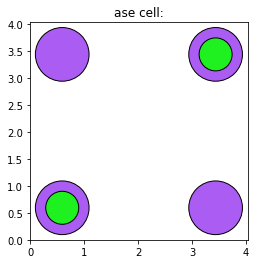

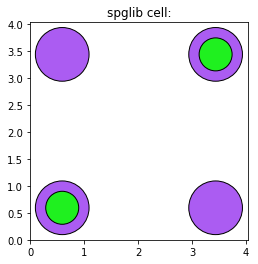

In [4]:
# Testing converting between spglib and ase cell formats

ase_cell = ase.io.read(poscar, format='vasp')
plot_cell_ase(ase_cell, 'ase cell:')
spglib_cell = get_spglib_from_ase(ase_cell)

ase_cell_fromSpglib = get_ase_from_spglib(spglib_cell)
plot_cell_ase(ase_cell_fromSpglib, 'spglib cell:')

In [5]:
# For viewing rotatable image in 3D with ase
# Note: hold down both mouse buttons or scroll to zoom and left mouse button to rotate
# For more info see here: https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html

ase.visualize.view(ase_cell_fromSpglib, viewer='x3d')

In [6]:
# Testing applying symmetry operations

# Obtain symmetry operations from spglib as dictionary with keys ['rotations'] and ['translations']
# in order with each other, i.e. together they form the symmetry operation

ase_cell_2D = ase.io.read(poscar_2D, format='vasp')
spglib_cell_2D = get_spglib_from_ase(ase_cell_2D)
symm_ops_2D = spg.get_symmetry(spglib_cell_2D, threshold)
# Combination of rotation and translation to give total symmetry operation
tot_symm_ops_2D = [(r, t) for r, t in zip(symm_ops_2D['rotations'], symm_ops_2D['translations'])]

print('Total symm operations for 2D test structure: '+str(len(tot_symm_ops_2D))+'\n')
print(symm_ops_2D['rotations'][20])
print(symm_ops_2D['translations'][20])
print('')

symm_ops = spg.get_symmetry(spglib_cell, threshold)
# Combination of rotation and translation to give total symmetry operation
tot_symm_ops = [(r, t) for r, t in zip(symm_ops['rotations'], symm_ops['translations'])]

print('Total symm operations for 3D test structure: '+str(len(tot_symm_ops))+'\n')
print(symm_ops['rotations'][50])
print(symm_ops['translations'][50])
print(symm_ops['translations'][50][2])


Total symm operations for 2D test structure: 32

[[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
[0.5 0.5 0. ]

Total symm operations for 3D test structure: 192

[[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  1]]
[0.5 0.5 0. ]
0.0


In [37]:
# Checking that space group (225) identified matches that from materials project (where structure was taken from)

print(spg.get_spacegroup(ase_cell, symprec=threshold))

Fm-3m (225)


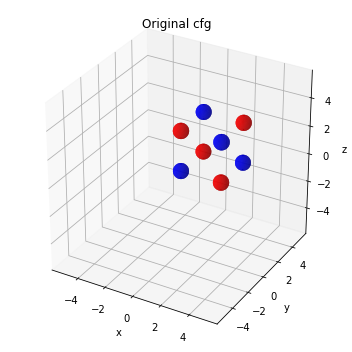

11 [0. 0. 0.]
11 [0.       2.845847 2.845847]
11 [2.845847 0.       2.845847]
11 [2.845847 2.845847 0.      ]
17 [0.       0.       2.845847]
17 [0.       2.845847 0.      ]
17 [2.845847 0.       0.      ]
17 [2.845847 2.845847 2.845847]


In [33]:
ase_cell = ase.io.read(poscar, format='vasp')
plot_cell_custom_3D(ase_cell, 'Original cfg')
positions = ase_cell.get_positions()
atom_types = ase_cell.get_atomic_numbers()
for atom, pos in zip(atom_types, positions):
    print(atom, pos)

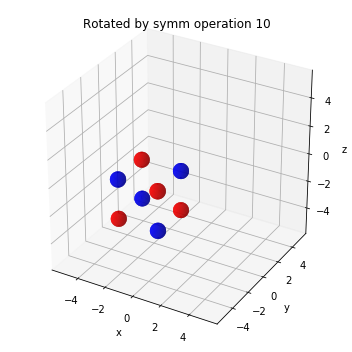

In [17]:
opp_num = 10

rotated = rotate_cfg(ase_cell, symm_ops['rotations'][opp_num])
plot_cell_custom_3D(rotated, 'Rotated by symm operation '+str(opp_num))

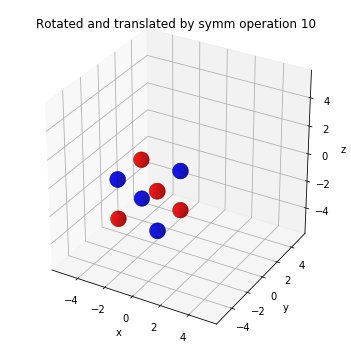

In [18]:
rotated_and_translated = translate_cfg(rotated, symm_ops['translations'][opp_num])
plot_cell_custom_3D(rotated_and_translated, 'Rotated and translated by symm operation '+str(opp_num))

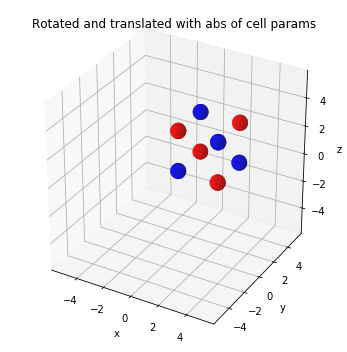

11 [0. 0. 0.]
11 [2.845847 0.       2.845847]
11 [0.       2.845847 2.845847]
11 [2.845847 2.845847 0.      ]
17 [0.       0.       2.845847]
17 [2.845847 0.       0.      ]
17 [0.       2.845847 0.      ]
17 [2.845847 2.845847 2.845847]


In [34]:
# Testing taking abs of translated and rotated cell

rotated_and_translated_abs_cell = abs_latt_vecs(rotated_and_translated)
plot_cell_custom_3D(rotated_and_translated_abs_cell, 'Rotated and translated with abs of cell params')
positions = rotated_and_translated_abs_cell.get_positions()
atom_types = rotated_and_translated_abs_cell.get_atomic_numbers()
for atom, pos in zip(atom_types, positions):
    print(atom, pos)

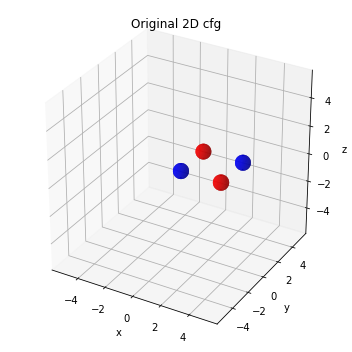

In [10]:
ase_cell_2D = ase.io.read(poscar_2D, format='vasp')
plot_cell_custom_3D(ase_cell_2D, 'Original 2D cfg')

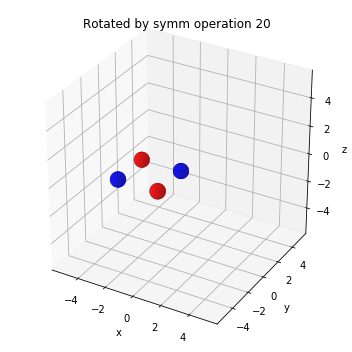

In [11]:
opp_num = 20

rotated_2D = rotate_cfg(ase_cell_2D, symm_ops_2D['rotations'][opp_num])
plot_cell_custom_3D(rotated_2D, 'Rotated by symm operation '+str(opp_num))

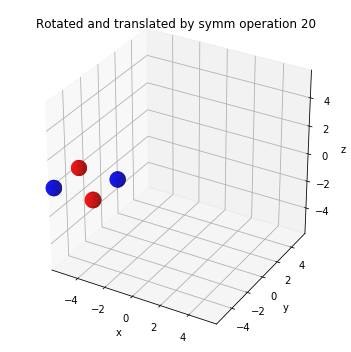

In [12]:
rotated_and_translated_2D = translate_cfg(rotated_2D, symm_ops_2D['translations'][opp_num])
plot_cell_custom_3D(rotated_and_translated_2D, 'Rotated and translated by symm operation '+str(opp_num))

In [13]:
# Investigating symm ops and hall notation
# Comparing symm ops outputted from get_symmetry to get_symmetry_from_database (using Hall num) appear the same


hall_number = spg.get_hall_number_from_symmetry(symm_ops['rotations'], symm_ops['translations'], symprec=threshold)
print(hall_number)
print(spg.get_spacegroup_type(hall_number))

hall_symm_ops = spg.get_symmetry_from_database(hall_number)

for orig, hall in zip(symm_ops['rotations'], hall_symm_ops['rotations']):
    print(orig, hall)

523
{'number': 225, 'international_short': 'Fm-3m', 'international_full': 'F 4/m -3 2/m', 'international': 'F m -3 m', 'schoenflies': 'Oh^5', 'hall_symbol': '-F 4 2 3', 'choice': '', 'pointgroup_schoenflies': 'm-3m', 'pointgroup_international': 'Oh', 'arithmetic_crystal_class_number': 72, 'arithmetic_crystal_class_symbol': 'm-3mF'}
[[1 0 0]
 [0 1 0]
 [0 0 1]] [[1 0 0]
 [0 1 0]
 [0 0 1]]
[[-1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]] [[-1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]
[[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  1]] [[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  1]]
[[ 0  1  0]
 [-1  0  0]
 [ 0  0 -1]] [[ 0  1  0]
 [-1  0  0]
 [ 0  0 -1]]
[[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]] [[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
[[ 1  0  0]
 [ 0  1  0]
 [ 0  0 -1]] [[ 1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
[[ 0  1  0]
 [-1  0  0]
 [ 0  0  1]] [[ 0  1  0]
 [-1  0  0]
 [ 0  0  1]]
[[ 0 -1  0]
 [ 1  0  0]
 [ 0  0 -1]] [[ 0 -1  0]
 [ 1  0  0]
 [ 0  0 -1]]
[[ 1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]] [[ 1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]
[[-1  0  0]
 [ 0  

In [22]:
print(ase_cell.get_cell())
print('')
print(symm_ops['rotations'][10])
print('')
print(np.matmul(ase_cell.get_cell(), symm_ops['rotations'][10]))
print('')
print(np.matmul(symm_ops['rotations'][10], ase_cell.get_cell()))

[[5.691694 0.       0.      ]
 [0.       5.691694 0.      ]
 [0.       0.       5.691694]]

[[ 0.       -5.691694  0.      ]
 [-5.691694  0.        0.      ]
 [ 0.        0.       -5.691694]]

[[ 0.       -5.691694  0.      ]
 [-5.691694  0.        0.      ]
 [ 0.        0.       -5.691694]]


In [ ]:
# Test of taking abs of lattvecs:

# To-do:
## Develop unique representation on cfg based on coords and atom num/ type (ID)
## Apply all 192 symm ops of 3D test structure to itself + take abs of lattvecs
## Check that ID of all 192 trans+rot+abs cfgs match that of original ID


In [95]:
test_comparison = compare_cfgs(ase_cell, rotated_and_translated_abs_cell)

8


In [96]:
print(test_comparison)

True


In [107]:
# Test all symm ops for 3D structure

symm_op_count = len(symm_ops['rotations'])

same_cfg_count = 0
for op_num in range(symm_op_count):
    symm_cfg = all_operations(ase_cell, symm_ops, op_num)
    is_same_as_orig = compare_cfgs(ase_cell, symm_cfg)
    if not is_same_as_orig:
        print('Uh oh, strucuture is not the same as the original!')
    else: 
        same_cfg_count += 1
        
print('Number of symmetry operations: '+str(symm_op_count))
print('Number of same structures: '+str(same_cfg_count))

Number of symmetry operations: 192
Number of same structures: 192


In [14]:
# TESTING DEGENERACY ALGORITHM

'''
Plan:

- Create parent of cfg by making all species Co or Mn (check if both have same no. of symm ops or if one has more)
- Use spglib to get symm ops of parent
- Get unique binary representation of TM site occupation as unique ID (int)
- Create all random TM substitutions for cfg (on td or oh sites depending on if set A or B)
-- For each random cfg generated, apply all parent symm ops, generate ID
-- If any IDs match orig cfg ID --> degeneracy += 1 and move on to next random structure

'''

'\nPlan:\n\n- Create parent of cfg by making all species Co or Mn (check if both have same no. of symm ops or if one has more)\n- Use spglib to get symm ops of parent\n- Get unique binary representation of TM site occupation as unique ID (int)\n- Create all random TM substitutions for cfg (on td or oh sites depending on if set A or B)\n-- For each random cfg generated, apply all parent symm ops, generate ID\n-- If any IDs match orig cfg ID --> degeneracy += 1 and move on to next random structure\n\n'

In [35]:
# !!Need to adapt function below because Co sites are not in order as before!! #

# Observation of CONTCARs: atoms always ordered as 8 td sites first, 16 oh sites after

# Ideas: 
## For each cfg one at a time, read in the 24 coords for each cfg (top of CONTCAR), first 8 are td
## Create list with number of Co and Mn read in from CONTCAR for td and Mn separately
## Randomly shuffle list of td and oh TMs to create new structures (keeping number const.)
## !!Check order of coords after applying symm ops!!


# Function to generate unique single int id for each structure based on Co and Mn site occupation
# with unique sites from 0 to 23

def generate_id_ordered(Co_sites):
    # Initialise empty list of 0's (Mn = 0)
    cfg_id_list = [0]*24
    # Assign all Co's to be 1
    for site in Co_sites:
        cfg_id_list[site] = 1
    # Convert list to string
    cfg_id_bin = "" 
    for item in cfg_id_list:
        cfg_id_bin += str(item)
    # Convert binary to int
    cfg_id = int(cfg_id_bin, 2)
    
    return cfg_id
